# Circular Convolutional Layers in the Fourier Domain
--------------------------------------------------------
This is a tutorial accompanying the ICLR 2021 paper *"Orthogonalizing Convolutional Layers with the Cayley Transform"* by Asher Trockman and Zico Kolter.

This Jupyter notebook is best viewed with [nbviewer (click here)](https://nbviewer.jupyter.org/github/locuslab/orthogonal-convolutions/blob/main/FFT%20Convolutions.ipynb).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]

### Quick start

In [2]:
# Try changing these parameters and running the notebook.
cin = 3      # input channels
cout = 3     # output channels
n = 5        # spatial (input) size
k = 3        # conv. kernel size
batches = 1  # batches

We will implement the following circular convolution using FFT functions:

In [3]:
x = torch.randn(batches, cin, n, n)
conv = nn.Conv2d(cin, cout, k, bias=False)

Notice that we make the convolution "circular" using circular padding (below). The left/right and top/bottom paddings differ to account for even kernel sizes (they will all be the same for odd kernel sizes).

In [4]:
y1 = conv(F.pad(x, ((k - 1) // 2, k // 2, (k - 1) // 2, k // 2), mode="circular"))

First, we compute the 2D FFT of the input (applied only to the last two dimensions):

In [5]:
xfft = torch.fft.fft2(x)

Then we compute the 2D FFT of the weights, also applied to only the last two dimensions.
We have to do a couple things here, however: first, we have to pad the weights to have the
same spatial size as the inputs.  

In [6]:
wpad = F.pad(conv.weight, (0, n - k, 0, n - k))

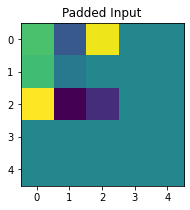

In [7]:
plt.title('Padded Input')
plt.imshow(wpad.detach()[0, 0]); plt.show()

Next, in order to agree with the circular convolution implemented in PyTorch, we have to shift the kernel to the "center" of the input field, which is the top left corner. We could implement this using `torch.roll` operations, but we found that it is easier and more efficient to center the kernel
in the Fourier domain using the [shift theorem](https://ccrma.stanford.edu/~jos/st/Shift_Theorem.html).

We construct a "shift matrix" and then use it in an elementwise product in the Fourier domain. The *shift amount* ensures that the center of the kernel is in the top left of the input field; the remainder of the kernel wraps around as if the input were "circular".

In [8]:
def fft_shift_matrix(n, shift_amount):
    shift = torch.arange(0, n).repeat((n, 1))
    shift = shift + shift.T
    return torch.exp(1j * 2 * np.pi * shift_amount * shift / n)
    
shift_amount = (k - 1) // 2
shift_matrix = fft_shift_matrix(n, -shift_amount)

Then, we also must take the complex conjugate. This is equivalent to flipping the kernel horizontally and vertically--
convolution as implemented in PyTorch is actually "cross-correlation" mathematically.
The difference is just that the kernel is flipped.
Conjugation in the Fourier domain is equivalent to flipping the signal in the spatial domain.
Refer to the [flip theorems](https://ccrma.stanford.edu/~jos/sasp/Flip_Theorems.html).

In [9]:
wfft = shift_matrix * torch.fft.fft2(wpad).conj()

The result of our Fourier-domain shifting and flipping operations can be seen below. Compare to the padded input above.

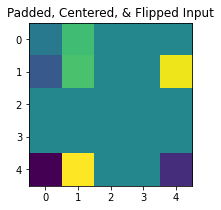

In [10]:
plt.title('Padded, Centered, & Flipped Input')
plt.imshow(torch.fft.ifft2(wfft)[0, 0].real.detach()); plt.show()

Then, we implement the product described by this figure, using `einsum`.<br><br>
<center>
<img width="200" src="https://github.com/locuslab/orthogonal-convolutions/blob/main/img/AnimationKeyVerySmall.gif?raw=true" alt="Multi-Channel 2D Convolution Theorem" /><br>
    <p style="width: 50%; min-width: 400px;">(<b>Colored slices:</b> pixels; <b>arrows:</b> dot products; <b>left:</b> Fourier-domain weights; <b>middle:</b> input tensor; <b>right:</b> output tensor; <b>bottom-right</b>: the matrix-vector product for each pixel.)</p>
</center><br>
That is: Each channel of each pixel of the output is the dot product of the corresponding input pixel and weight pixel.



In [11]:
yfft = torch.einsum('dchw, bchw -> bdhw', wfft, xfft)

Now we apply the inverse Fourier transform, and we're done.

In [12]:
y2 = torch.fft.ifft2(yfft)

The result is the same as the circular convolution we implemented with `nn.Conv2d`:

In [13]:
(y1 - y2).norm().item()

1.5329876532632625e-06

------------------------------------------------------------------------
### Matrix Block-Diagonalization Perspective
And how to orthogonalize FFT convolutions.

In [14]:
plt.rcParams['figure.figsize'] = [5, 5]

We can make a block diagonal Fourier-domain matrix out of the $n^2$ pixels of `wfft`.
Then, we can implement circular convolution in the Fourier domain by multiplying the Fourier-domain
inputs with the block diagonal matrix.

In [15]:
D = torch.block_diag(*[wfft.reshape(cin, cout, n**2)[..., i] for i in range(n**2)])

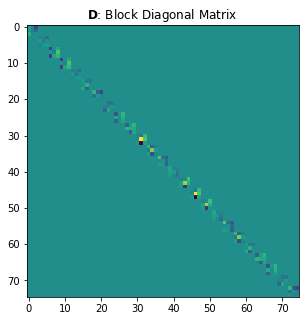

In [16]:
plt.imshow(D.real.detach())
plt.title(r'$\bf{D}$: Block Diagonal Matrix')
plt.show()

We have to reshape the input into a batch of vectors, where we lay out the channels first. That is,
the first `cin` elements of the vector belong to the first pixel, the next `cin` to the second pixel,
and so on.

Then, we multiply by the diagonal matrix `D` and convert back to the original input shape.

In [17]:
yfft_matrix = (D @ xfft.reshape(batches, cin, n**2).permute(2, 1, 0).reshape(-1, batches)) \
                .reshape(n, n, cin, batches).permute(3, 2, 0, 1)

Again, this is the same as doing circular convolution using `nn.Conv2d`, as well as our previous implementation of Fourier convolutions. We apply the inverse 2D FFT and compare:

In [18]:
y3 = torch.fft.ifft2(yfft_matrix)
(y1 - y3).norm().item()

1.5019836610008497e-06

-----------------------------------------
We will now illustrate the "block diagonalization" part of this figure by constructing DFT matrices that convert the previous block diagonal matrix `D` into a block matrix of convolution matrices `C`:
<center>
    <img width="300" src="https://github.com/locuslab/orthogonal-convolutions/blob/main/img/ICLR-Thumbnail-Fourier.001.png?raw=true" alt="Block-Diagonalization in the Fourier Domain" />
</center>

In [19]:
# Somewhat easier to build these matrices with np.block
import numpy as np 

# Perfect shuffle matrices, implemented as described in the appendix of our paper
def shuffle_matrix(p, q):
    r = p * q
    Ir = np.eye(r)
    S = []
    for i in range(q):
        for x in Ir[i:r:q]:
            S.append([x])
    return np.block(S)

# The "script F" matrix from Corollary A.1.1 of our paper
def script_F(c):
    global n
    S = shuffle_matrix(c, n**2)
    F = np.fft.fft(np.eye(n), norm="ortho")
    FF = np.kron(F, F)
    return S @ np.kron(np.eye(c), FF)

In [20]:
Fs_cout = torch.tensor(script_F(cout), dtype=torch.complex64)
Fs_cin = torch.tensor(script_F(cin), dtype=torch.complex64)

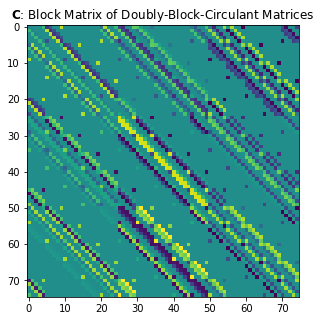

In [21]:
C = Fs_cout.conj().T @ D @ Fs_cin
plt.imshow(C.real.detach())
plt.title(r'$\bf{C}$: Block Matrix of Doubly-Block-Circulant Matrices')
plt.show()

This matrix `C` represents the circular convolution in the spatial domain.
We reshape the input vector such that the $n^2$ pixels of the first channel come first,
then the second channel, and so on:

In [22]:
y_matrix = (C.real @ x.reshape(batches, cin, n**2).permute(1, 2, 0).reshape(-1, batches)) \
                .reshape(cin, n, n, batches).permute(3, 0, 1, 2)

In [23]:
(y_matrix - y3).norm().item()

1.3579970072896685e-06

We will now make the claim in the figure above explicit: applying the Cayley transform to `C` is equivalent to applying the Cayley transform to `D` and then applying the DFT matrices:

In [24]:
assert cin == cout, "This section only applies for cin == cout, since we need square matrices"
cayley = lambda B: (torch.eye(cin * n**2) - B + B.conj().T) @ torch.inverse(torch.eye(cin * n**2) + B - B.conj().T)

In [25]:
(cayley(C) - Fs_cin.conj().T @ cayley(D) @ Fs_cin).norm().item()

2.071995368169155e-06

What does an orthogonal convolution look like, anyways?

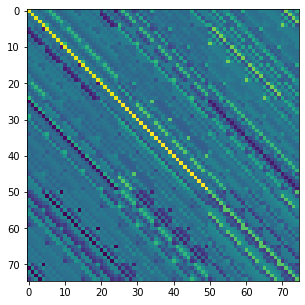

In [26]:
C_ortho = cayley(C)
plt.imshow(C_ortho.detach().numpy().real)
plt.show()

As an aside, note that the imaginary part of `C_ortho` (and `C`) is zero:

In [27]:
C_ortho.imag.norm().item(), C.imag.norm().item()

(2.275218548675184e-06, 1.0707211686167284e-06)

Let's illustrate that `C_ortho` is indeed orthogonal:

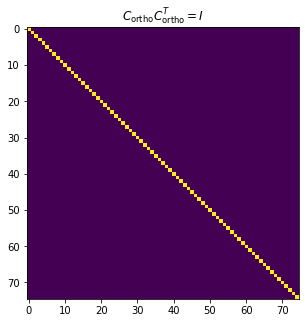

In [28]:
plt.imshow((C_ortho @ C_ortho.T).detach().numpy().real)
plt.title(r"$C_\mathsf{ortho} C_\mathsf{ortho}^T = I$")
plt.show()

--------------------------------------------------------
## Orthogonalizing FFT Convolutions

Putting the ideas illustrated above together, we want to orthogonalize
a convolution in the Fourier domain without explicitly constructing a large matrix.
Essentially, we just want to operate on the blocks of `D`.
Recall that we extracted those blocks from the convolution weight tensor earlier:
*we will just rearrange the tensor to make working with those blocks easier.*

In particular, we will use the fact that each pixel of the output is given by a matrix vector product:
we will arrange the input and weight tensors so that we can compute the convolution
with a batch of such matrix multiplications.

In [29]:
xfft = torch.fft.fft2(x)
xfft = xfft.permute(2, 3, 1, 0) # batches, cin, n, n -> n, n, cin, batches
xfft = xfft.reshape(n**2, cin, batches) # n**2 input pixels

In [30]:
wfft = shift_matrix * torch.fft.fft2(wpad).conj() # cout, cin, n, n
wfft = wfft.reshape(cout, cin, n**2) # cout, cin, n**2 pixels
wfft = wfft.permute(2, 0, 1) # n**2, cout, cin

Now, similarly to the block diagonal matrix `D` earlier,
we have `xfft` of shape ($n^2$, `cin`, `batches`) and
`wfft` of shape ($n^2$, `cout`, `cin`).
The last two dimensions for each of these are compatible for matrix multiplication with output
shape ($n^2$, `cout`, `batches`).

We can do batch matrix multiplication, and reshape again:

In [31]:
yfft = wfft @ xfft # n**2, cout, batches
yfft = yfft.reshape(n, n, cout, batches)
yfft = yfft.permute(3, 2, 0, 1) # batches, cout, n, n
y4 = torch.fft.ifft2(yfft)

Again, this is equivalent to the original circular convolution:

In [32]:
(y1 - y4).norm().item()

1.5329876532632625e-06

But this time, it's very easy to orthogonalize the convolution by orthogonalizing
all of the "blocks":

In [33]:
# "Batched" Cayley transform
wfft_skew_sym = wfft - wfft.conj().transpose(1, 2)
I = torch.eye(cin, dtype=wfft.dtype)[None, :, :]
wfft_ortho = (I - wfft_skew_sym) @ torch.inverse(I + wfft_skew_sym)

In [34]:
yfft_ortho = wfft_ortho @ xfft # n**2, cout, batches
yfft_ortho = yfft_ortho.reshape(n, n, cout, batches)
yfft_ortho = yfft_ortho.permute(3, 2, 0, 1) # batches, cout, n, n
y_ortho = torch.fft.ifft2(yfft_ortho)

We can see that this implements an orthogonal convolution because
it doesn't expand the norm of input tensors:

In [35]:
print('y_ortho   norm: ', y_ortho.norm().item())
print('input (x) norm: ', x.norm().item())

y_ortho   norm:  8.151487350463867
input (x) norm:  8.151487350463867


---------------------------------------------------------------------
### Optimizations and More

Using the symmetry of the Fourier transform, we can implement FFT-based convolutions
even more efficiently. We can also handle strided FFT-based convolutions using the *aliasing theorem*, which can be found [here](https://ccrma.stanford.edu/~jos/st/Downsampling_Theorem_Aliasing_Theorem.html).

We provide a more fully-featured FFT-based convolution layer in `extras/fftconv.py`.

In [38]:
from extras.fftconv import FFTConv

fft_conv = FFTConv(cin, cout, k, bias=False)
fft_conv.weight.data = conv.weight.data

(fft_conv(x) - y1).norm().item()

1.0860642305488e-06

### Orthogonal Convolutions when `cin` != `cout`

In the appendix of our paper, we describe a method to efficiently "orthogonalize" convolutions with different numbers of input and output channels. This is actually called *semi-orthogonalization*.
More details can be found in `Orthogonal Convolutions.ipynb`.

-----------------------------------------------------------------------
You can cite our work as follows:

<pre>
@inproceedings{trockman2021ortho,
    title={Orthogonalizing Convolutional Layers with the Cayley Transform},
    author={Asher Trockman and J. Zico Kolter},
    booktitle={International Conference on Learning Representations},
    year={2021},
    url={https://openreview.net/forum?id=Pbj8H_jEHYv}
}
</pre>